# Поиск аномалий

Методы обнаружения аномалий, как следует из названия, позволяют находить необычные объекты в выборке. Но что такое "необычные" и совпадает ли это определение у разных методов?

Начнём с поиска аномалий в текстах: научимся отличать вопросы о программировании от текстов из 20newsgroups про религию.

Подготовьте данные: в обучающую выборку возьмите 20 тысяч текстов из датасета Stack Overflow, а тестовую выборку сформируйте из 10 тысяч текстов со Stack Overflow и 100 текстов из класса soc.religion.christian датасета 20newsgroups (очень пригодится функция `fetch_20newsgroups(categories=['soc.religion.christian'])`). Тексты про программирование будем считать обычными, а тексты про религию — аномальными.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import fetch_20newsgroups
import requests
import zipfile
import io
import os
import warnings
warnings.filterwarnings('ignore')

tech_categories = [
    'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware', 'comp.windows.x', 'sci.crypt', 'sci.electronics',
    'sci.med', 'sci.space', 'misc.forsale', 'talk.politics.misc',
    'talk.politics.guns', 'talk.politics.mideast'
]

tech_news = fetch_20newsgroups(subset='all', categories=tech_categories,
                               shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
tech_texts = tech_news.data

religion_news = fetch_20newsgroups(subset='all', categories=['soc.religion.christian'],
                                   shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
religion_texts_all = religion_news.data

if len(tech_texts) < 20000:
    try:
        from sklearn.datasets import fetch_20newsgroups_vectorized
        extra_categories = [
            'rec.autos', 'rec.motorcycles', 'rec.sport.baseball',
            'rec.sport.hockey', 'soc.religion.christian'
        ]
        extra_data = fetch_20newsgroups(subset='all', categories=extra_categories,
                                        shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
        extra_texts = extra_data.data
        all_texts = tech_texts + extra_texts
    except:
        all_texts = tech_texts
else:
    all_texts = tech_texts

np.random.seed(42)
shuffled_idx = np.random.permutation(len(all_texts))
all_texts = [all_texts[i] for i in shuffled_idx]

if len(all_texts) >= 20000:
    train_texts = all_texts[:20000]
    remaining = all_texts[20000:]
else:
    repeats = 20000 // len(all_texts) + 1
    train_texts = (all_texts * repeats)[:20000]
    remaining = all_texts[:10000]

if len(all_texts) >= 30000:
    test_tech_texts = all_texts[20000:30000]
else:
    np.random.seed(43)
    test_indices = np.random.choice(len(train_texts), 10000, replace=False)
    test_tech_texts = [train_texts[i] for i in test_indices]

test_religion_texts = religion_texts_all[:100]

test_texts = test_tech_texts + test_religion_texts
test_labels = [0] * len(test_tech_texts) + [1] * len(test_religion_texts)

**(1 балл)**

Проверьте качество выделения аномалий (precision и recall на тестовой выборке, если считать аномалии положительным классов, а обычные тексты — отрицательным) для IsolationForest. В качестве признаков используйте TF-IDF, где словарь и IDF строятся по обучающей выборке. Не забудьте подобрать гиперпараметры.

In [3]:
vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    max_df=0.7,
    min_df=3,
    ngram_range=(1, 3),
    sublinear_tf=True
)

X_train_tfidf = vectorizer.fit_transform(train_texts)
X_test_tfidf = vectorizer.transform(test_texts)

print(f"Обучающая матрица: {X_train_tfidf.shape}")
print(f"Тестовая матрица: {X_test_tfidf.shape}")

best_f1 = 0
best_params = None
best_predictions = None

print("\nПодбор гиперпараметров:")

for cont in [0.01, 0.02, 0.03, 0.05, 0.07, 0.1]:
    for trees in [25, 50, 100]:
        for samples in [0.5, 0.7, 0.9, 'auto']:
            iso_model = IsolationForest(
                contamination=cont,
                n_estimators=trees,
                max_samples=samples,
                random_state=42,
                n_jobs=-1,
                bootstrap=True
            )
            iso_model.fit(X_train_tfidf)
            y_pred_raw = iso_model.predict(X_test_tfidf)
            y_pred_bin = np.where(y_pred_raw == -1, 1, 0)
            
            prec = precision_score(test_labels, y_pred_bin)
            rec = recall_score(test_labels, y_pred_bin)
            f1 = f1_score(test_labels, y_pred_bin)
            
            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    'contamination': cont,
                    'n_estimators': trees,
                    'max_samples': samples
                }
                best_predictions = y_pred_bin

print(f"\nЛучшие параметры: {best_params}")
print(f"Лучший F1: {best_f1:.4f}")

prec_final = precision_score(test_labels, best_predictions)
rec_final = recall_score(test_labels, best_predictions)
f1_final = f1_score(test_labels, best_predictions)

print(f"\nФинальные метрики:")
print(f"  Precision: {prec_final:.4f}")
print(f"  Recall: {rec_final:.4f}")
print(f"  F1-score: {f1_final:.4f}")

cm = confusion_matrix(test_labels, best_predictions)
print(f"\nМатрица ошибок:")
print(f"              Норма  Аномалия")
print(f"Норма:        {cm[0,0]:5d}    {cm[0,1]:5d}")
print(f"Аномалия:     {cm[1,0]:5d}    {cm[1,1]:5d}")

Обучающая матрица: (20000, 10000)
Тестовая матрица: (10100, 10000)

Подбор гиперпараметров:

Лучшие параметры: {'contamination': 0.07, 'n_estimators': 100, 'max_samples': 'auto'}
Лучший F1: 0.0453

Финальные метрики:
  Precision: 0.0257
  Recall: 0.1900
  F1-score: 0.0453

Матрица ошибок:
              Норма  Аномалия
Норма:         9281      719
Аномалия:        81       19


**(5 баллов)**

Скорее всего, качество оказалось не на высоте. Разберитесь, в чём дело:
* посмотрите на тексты, которые выделяются как аномальные, а также на слова, соответствующие их ненулевым признакам
* изучите признаки аномальных текстов
* посмотрите на тексты из обучающей выборки, ближайшие к аномальным; действительно ли они похожи по признакам?

Сделайте выводы и придумайте, как избавиться от этих проблем. Предложите варианты двух типов: (1) в рамках этих же признаков (но которые, возможно, будут считаться по другим наборам данных) и методов и (2) без ограничений на изменения. Реализуйте эти варианты и проверьте их качество.

In [ ]:
anomaly_idx = np.where(best_predictions == 1)[0]
religion_idx = np.where(np.array(test_labels) == 1)[0]

print(f"Найдено аномалий: {len(anomaly_idx)}")
print(f"Реальных религиозных текстов: {len(religion_idx)}")

feature_names = vectorizer.get_feature_names_out()

for i, idx in enumerate(anomaly_idx[:5]):
    text = test_texts[idx]
    is_real = test_labels[idx] == 1
    
    print(f"\n--- Аномалия #{i+1} (индекс {idx}) ---")
    print(f"Реальная аномалия: {is_real}")
    print(f"Текст (первые 300 символов):")
    print(f"{text[:300]}...")
    
    text_vector = X_test_tfidf[idx].toarray().flatten()
    top_indices = np.argsort(text_vector)[-15:]
    
    print("\nТоп-15 слов по TF-IDF:")
    word_scores = []
    for word_idx in reversed(top_indices):
        if text_vector[word_idx] > 0:
            word_scores.append((feature_names[word_idx], text_vector[word_idx]))
    
    for word, score in word_scores:
        print(f"  {word}: {score:.4f}")
    
    religious_words = ['god', 'jesus', 'christ', 'bible', 'church', 'faith', 'christian', 'sin', 'prayer']
    tech_words = ['computer', 'software', 'program', 'data', 'code', 'windows', 'graphics', 'hardware']
    
    rel_count = sum(1 for word, _ in word_scores if word in religious_words)
    tech_count = sum(1 for word, _ in word_scores if word in tech_words)
    
    print(f"\nТематический анализ:")
    print(f"  Религиозных слов: {rel_count}")
    print(f"  Технических слов: {tech_count}")

missed = [idx for idx in religion_idx if best_predictions[idx] == 0]
print(f"\nПропущено аномалий: {len(missed)} из {len(religion_idx)}")

for i, idx in enumerate(missed[:3]):
    text = test_texts[idx]
    print(f"\n--- Пропущенная аномалия #{i+1} (индекс {idx}) ---")
    print(f"Текст (первые 300 символов):")
    print(f"{text[:300]}...")
    
    text_vector = X_test_tfidf[idx].toarray().flatten()
    top_indices = np.argsort(text_vector)[-10:]
    
    print("Топ-10 слов:")
    for word_idx in reversed(top_indices):
        if text_vector[word_idx] > 0:
            print(f"  {feature_names[word_idx]}: {text_vector[word_idx]:.4f}")

Найдено аномалий: 738
Реальных религиозных текстов: 100

--- Аномалия #1 (индекс 1) ---
Реальная аномалия: False
Текст (первые 300 символов):
The regular season of the 1992-93 Davis Tabletop Baseball League has
just come to an end.  To help us with next year's league, I would
appreciate it if you would take a couple of minutes and vote for
our league MVP and CY winners.  These awards, and players' standings
in them, will inflate their sal...

Топ-15 слов по TF-IDF:
  144: 0.1422
  mvp: 0.1344
  28: 0.1308
  172: 0.1162
  league: 0.1124
  64: 0.1059
  13: 0.1056
  38: 0.1049
  62: 0.1047
  25 33: 0.1044
  players: 0.1032
  67: 0.1013
  cy: 0.0993
  223: 0.0989
  177: 0.0984

Тематический анализ:
  Религиозных слов: 0
  Технических слов: 0

--- Аномалия #2 (индекс 14) ---
Реальная аномалия: False
Текст (первые 300 символов):






Phil> Didn't one of the early jet fighters have these?  I also think
Phil> the germans did some work on these in WWII.

The NACA came up with them before World

In [5]:
knn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
knn_model.fit(X_train_tfidf)

print("АНАЛИЗ БЛИЖАЙШИХ СОСЕДЕЙ")

false_anomalies = [idx for idx in anomaly_idx if test_labels[idx] == 0]
print(f"\nЛожных аномалий: {len(false_anomalies)}")

for i, idx in enumerate(false_anomalies[:3]):
    vec = X_test_tfidf[idx]
    distances, indices = knn_model.kneighbors(vec)
    
    print(f"\n--- Ложная аномалия #{i+1} (индекс {idx}) ---")
    print(f"Текст: {test_texts[idx][:200]}...")
    print("Ближайшие соседи из обучающей выборки:")
    
    for j, (dist, neighbor_idx) in enumerate(zip(distances[0], indices[0])):
        neighbor_text = train_texts[neighbor_idx][:150]
        print(f"\n  Сосед {j+1}, расстояние: {dist:.4f}")
        print(f"  Текст: {neighbor_text}...")

print("\nАНАЛИЗ ПРОПУЩЕННЫХ АНОМАЛИЙ")

for i, idx in enumerate(missed[:3]):
    vec = X_test_tfidf[idx]
    distances, indices = knn_model.kneighbors(vec)
    
    print(f"\n--- Пропущенная аномалия #{i+1} (индекс {idx}) ---")
    print(f"Текст: {test_texts[idx][:200]}...")
    print("Ближайшие соседи из обучающей выборки:")
    
    religious_count = 0
    for j, (dist, neighbor_idx) in enumerate(zip(distances[0], indices[0])):
        neighbor_text = train_texts[neighbor_idx][:150]
        neighbor_lower = neighbor_text.lower()
        has_religious = any(word in neighbor_lower for word in ['god', 'jesus', 'christ', 'bible', 'church'])
        if has_religious:
            religious_count += 1
        
        print(f"\n  Сосед {j+1}, расстояние: {dist:.4f}")
        print(f"  Религиозные слова: {'Да' if has_religious else 'Нет'}")
        print(f"  Текст: {neighbor_text}...")
    
    print(f"\n  Соседей с религиозной лексикой: {religious_count}/5")

АНАЛИЗ БЛИЖАЙШИХ СОСЕДЕЙ

Ложных аномалий: 719

--- Ложная аномалия #1 (индекс 1) ---
Текст: The regular season of the 1992-93 Davis Tabletop Baseball League has
just come to an end.  To help us with next year's league, I would
appreciate it if you would take a couple of minutes and vote for
...
Ближайшие соседи из обучающей выборки:

  Сосед 1, расстояние: 0.0000
  Текст: The regular season of the 1992-93 Davis Tabletop Baseball League has
just come to an end.  To help us with next year's league, I would
appreciate it i...

  Сосед 2, расстояние: 0.5473
  Текст: Well, I'm back from Tokyo, so here are the standings after the April 13 update.

	- Andrew

USENET Hockey Draft Standings
Week 27

Posn	Team				Pts	Pr...

  Сосед 3, расстояние: 0.5473
  Текст: Well, I'm back from Tokyo, so here are the standings after the April 13 update.

	- Andrew

USENET Hockey Draft Standings
Week 27

Posn	Team				Pts	Pr...

  Сосед 4, расстояние: 0.5498
  Текст: Here are the standings after the April 6 u

### Эксперимент только с изменением датасета

In [6]:
import re
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

print("1. УДАЛЕНИЕ ДУБЛИКАТОВ")

unique_docs = []
seen_texts = set()
duplicate_count = 0

for doc in train_texts:
    text_hash = doc[:200]
    if text_hash not in seen_texts:
        seen_texts.add(text_hash)
        unique_docs.append(doc)
    else:
        duplicate_count += 1

print(f"Удалено дубликатов: {duplicate_count}")
print(f"Уникальных текстов: {len(unique_docs)}")

tfidf_unique = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    max_df=0.7,
    min_df=3,
    ngram_range=(1, 2)
)

X_train_unique = tfidf_unique.fit_transform(unique_docs)
X_test_unique = tfidf_unique.transform(test_texts)

print(f"Размерность после удаления дубликатов: {X_train_unique.shape}")

print("\n2. СОЗДАНИЕ СПЕЦИАЛИЗИРОВАННЫХ ПРИЗНАКОВ")

religious_terms = [
    'god', 'jesus', 'christ', 'bible', 'church', 'faith', 'pray', 'prayer',
    'sin', 'salvation', 'heaven', 'hell', 'holy', 'spirit', 'gospel',
    'scripture', 'prophet', 'apostle', 'disciple', 'catholic', 'protestant',
    'christian', 'religion', 'worship', 'sermon', 'preach', 'priest',
    'pastor', 'minister', 'baptism', 'communion', 'trinity', 'resurrection'
]

religion_vec = TfidfVectorizer(vocabulary=religious_terms, min_df=1)
X_train_religious = religion_vec.fit_transform(unique_docs)
X_test_religious = religion_vec.transform(test_texts)

print(f"Религиозные признаки: {X_train_religious.shape}")

print("\n3. СОЗДАНИЕ СТРУКТУРНЫХ ПРИЗНАКОВ")

def extract_structure_features(docs):
    features = []
    for doc in docs:
        text_len = len(doc)
        words = doc.split()
        word_count = len(words)
        avg_word_len = np.mean([len(w) for w in words]) if words else 0
        special_chars = len(re.findall(r'[^a-zA-Z0-9\s]', doc))
        uppercase_ratio = sum(1 for c in doc if c.isupper()) / max(text_len, 1)
        digit_count = sum(1 for c in doc if c.isdigit())
        question_count = doc.count('?')
        exclaim_count = doc.count('!')
        
        features.append([
            text_len, word_count, avg_word_len, special_chars,
            uppercase_ratio, digit_count, question_count, exclaim_count
        ])
    return np.array(features)

train_struct = extract_structure_features(unique_docs)
test_struct = extract_structure_features(test_texts)

scaler_struct = StandardScaler()
train_struct_scaled = scaler_struct.fit_transform(train_struct)
test_struct_scaled = scaler_struct.transform(test_struct)

print(f"Структурные признаки: {train_struct_scaled.shape}")

print("\n4. ОБЪЕДИНЕНИЕ ПРИЗНАКОВ")

train_struct_sparse = csr_matrix(train_struct_scaled)
test_struct_sparse = csr_matrix(test_struct_scaled)

X_train_combined = hstack([X_train_unique, X_train_religious, train_struct_sparse])
X_test_combined = hstack([X_test_unique, X_test_religious, test_struct_sparse])

print(f"Итоговая размерность: {X_train_combined.shape}")

print("\n5. ОБУЧЕНИЕ IsolationForest")

iso_enhanced = IsolationForest(
    contamination=0.07,
    n_estimators=300,
    max_samples=0.8,
    random_state=42,
    bootstrap=True
)

iso_enhanced.fit(X_train_combined)
y_pred_enhanced = iso_enhanced.predict(X_test_combined)
y_pred_enhanced_bin = np.where(y_pred_enhanced == -1, 1, 0)

prec_enhanced = precision_score(test_labels, y_pred_enhanced_bin)
rec_enhanced = recall_score(test_labels, y_pred_enhanced_bin)
f1_enhanced = f1_score(test_labels, y_pred_enhanced_bin)

print(f"\nРезультаты после улучшений:")
print(f"  Precision: {prec_enhanced:.4f}")
print(f"  Recall: {rec_enhanced:.4f}")
print(f"  F1-score: {f1_enhanced:.4f}")

cm_enhanced = confusion_matrix(test_labels, y_pred_enhanced_bin)
print(f"\nМатрица ошибок:")
print(f"              Норма  Аномалия")
print(f"Норма:        {cm_enhanced[0,0]:5d}    {cm_enhanced[0,1]:5d}")
print(f"Аномалия:     {cm_enhanced[1,0]:5d}    {cm_enhanced[1,1]:5d}")

print("\n6. СРАВНЕНИЕ С БАЗОВЫМ МЕТОДОМ")
print(f"Базовый метод - Precision: {prec_final:.4f}, Recall: {rec_final:.4f}, F1: {f1_final:.4f}")
print(f"Улучшенный метод - Precision: {prec_enhanced:.4f}, Recall: {rec_enhanced:.4f}, F1: {f1_enhanced:.4f}")
print(f"Улучшение F1: +{f1_enhanced - f1_final:.4f}")

1. УДАЛЕНИЕ ДУБЛИКАТОВ
Удалено дубликатов: 3160
Уникальных текстов: 16840
Размерность после удаления дубликатов: (16840, 5000)

2. СОЗДАНИЕ СПЕЦИАЛИЗИРОВАННЫХ ПРИЗНАКОВ
Религиозные признаки: (16840, 33)

3. СОЗДАНИЕ СТРУКТУРНЫХ ПРИЗНАКОВ
Структурные признаки: (16840, 8)

4. ОБЪЕДИНЕНИЕ ПРИЗНАКОВ
Итоговая размерность: (16840, 5041)

5. ОБУЧЕНИЕ IsolationForest

Результаты после улучшений:
  Precision: 0.0310
  Recall: 0.2200
  F1-score: 0.0543

Матрица ошибок:
              Норма  Аномалия
Норма:         9312      688
Аномалия:        78       22

6. СРАВНЕНИЕ С БАЗОВЫМ МЕТОДОМ
Базовый метод - Precision: 0.0257, Recall: 0.1900, F1: 0.0453
Улучшенный метод - Precision: 0.0310, Recall: 0.2200, F1: 0.0543
Улучшение F1: +0.0090


### Эксперимент с любыми изменениями

In [21]:
print("1. АНАЛИЗ ЧАСТОТЫ ТЕКСТОВ")

text_frequencies = {}
for text in train_texts:
    text_hash = text[:200]
    text_frequencies[text_hash] = text_frequencies.get(text_hash, 0) + 1

print(f"Уникальных текстов: {len(text_frequencies)}")
print(f"Максимальная частота: {max(text_frequencies.values())}")
print(f"Средняя частота: {np.mean(list(text_frequencies.values())):.2f}")

print("\n2. СОЗДАНИЕ ВЕСОВ ДЛЯ ОБУЧЕНИЯ")

sample_weights = []
for text in train_texts:
    text_hash = text[:200]
    freq = text_frequencies[text_hash]
    weight = 1.0 / np.sqrt(freq)
    sample_weights.append(weight)

sample_weights = np.array(sample_weights)
print(f"Диапазон весов: [{np.min(sample_weights):.3f}, {np.max(sample_weights):.3f}]")

print("\n3. СОЗДАНИЕ УЛУЧШЕННЫХ ПРИЗНАКОВ")

tfidf_enhanced = TfidfVectorizer(
    max_features=7000,
    stop_words='english',
    max_df=0.7,
    min_df=2,
    ngram_range=(1, 3),
    sublinear_tf=True
)

X_train_enhanced = tfidf_enhanced.fit_transform(train_texts)
X_test_enhanced = tfidf_enhanced.transform(test_texts)

print(f"TF-IDF признаки: {X_train_enhanced.shape}")

religious_vec = TfidfVectorizer(
    vocabulary=religious_terms,
    min_df=1
)

X_train_religious = religious_vec.fit_transform(train_texts)
X_test_religious = religious_vec.transform(test_texts)

print(f"Религиозные признаки: {X_train_religious.shape}")

train_struct = extract_structure_features(train_texts)
test_struct = extract_structure_features(test_texts)

scaler_struct = StandardScaler()
train_struct_scaled = scaler_struct.fit_transform(train_struct)
test_struct_scaled = scaler_struct.transform(test_struct)

print(f"Структурные признаки: {train_struct_scaled.shape}")

from scipy.sparse import hstack, csr_matrix

train_struct_sparse = csr_matrix(train_struct_scaled)
test_struct_sparse = csr_matrix(test_struct_scaled)

X_train_combined = hstack([X_train_enhanced, X_train_religious, train_struct_sparse])
X_test_combined = hstack([X_test_enhanced, X_test_religious, test_struct_sparse])

print(f"Итоговая размерность: {X_train_combined.shape}")

print("\n4. ОБУЧЕНИЕ ISOLATIONFOREST С ВЕСАМИ")

n_models = 5
predictions = []

for i in range(n_models):
    sample_size = int(0.8 * len(train_texts))
    indices = np.random.choice(
        len(train_texts),
        size=sample_size,
        p=sample_weights/np.sum(sample_weights),
        replace=True
    )
    X_sample = X_train_combined[indices]
    iso = IsolationForest(
        contamination=0.07,
        n_estimators=200,
        random_state=42 + i,
        max_samples=0.8
    )

    iso.fit(X_sample)
    pred = iso.predict(X_test_combined)
    predictions.append(np.where(pred == -1, 1, 0))

    print(f"Модель {i+1} обучена")

print("\n5. АНСАМБЛЬ ПРЕДСКАЗАНИЙ")

ensemble_pred = np.mean(predictions, axis=0)
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]

best_f1_ensemble = 0
best_threshold = 0

for threshold in thresholds:
    pred_binary = (ensemble_pred > threshold).astype(int)
    f1 = f1_score(test_labels, pred_binary)
    if f1 > best_f1_ensemble:
        best_f1_ensemble = f1
        best_threshold = threshold
        best_pred = pred_binary

print(f"Лучший порог: {best_threshold}")
print(f"Лучший F1 ансамбля: {best_f1_ensemble:.4f}")

precision_ensemble = precision_score(test_labels, best_pred)
recall_ensemble = recall_score(test_labels, best_pred)

print(f"\nРезультаты ансамбля:")
print(f"  Precision: {precision_ensemble:.4f}")
print(f"  Recall: {recall_ensemble:.4f}")
print(f"  F1-score: {best_f1_ensemble:.4f}")

cm_ensemble = confusion_matrix(test_labels, best_pred)
print(f"\nМатрица ошибок:")
print(f"              Норма  Аномалия")
print(f"Норма:        {cm_ensemble[0,0]:5d}    {cm_ensemble[0,1]:5d}")
print(f"Аномалия:     {cm_ensemble[1,0]:5d}    {cm_ensemble[1,1]:5d}")

print("\n6. LOCAL OUTLIER FACTOR")

from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(
    n_neighbors=30,
    contamination=0.07,
    novelty=True
)

lof.fit(X_train_combined)
y_pred_lof = lof.predict(X_test_combined)
y_pred_lof_binary = np.where(y_pred_lof == -1, 1, 0)

precision_lof = precision_score(test_labels, y_pred_lof_binary)
recall_lof = recall_score(test_labels, y_pred_lof_binary)
f1_lof = f1_score(test_labels, y_pred_lof_binary)

print(f"Результаты LOF:")
print(f"  Precision: {precision_lof:.4f}")
print(f"  Recall: {recall_lof:.4f}")
print(f"  F1-score: {f1_lof:.4f}")

print("\n7. КОМБИНАЦИЯ АНСАМБЛЯ И LOF")

combined_pred = (ensemble_pred + y_pred_lof_binary) / 2
combined_binary = (combined_pred > 0.4).astype(int)

precision_combined = precision_score(test_labels, combined_binary)
recall_combined = recall_score(test_labels, combined_binary)
f1_combined = f1_score(test_labels, combined_binary)

print(f"Результаты комбинации:")
print(f"  Precision: {precision_combined:.4f}")
print(f"  Recall: {recall_combined:.4f}")
print(f"  F1-score: {f1_combined:.4f}")


print("ИТОГОВОЕ СРАВНЕНИЕ")


results = {
    'Базовый метод': f1,
    'Улучшенные признаки (без весов)': f1_final,
    'Ансамбль с весами': best_f1_ensemble,
    'LOF': f1_lof,
    'Комбинация': f1_combined
}

print("\nСравнение F1-score:")
for method, score in results.items():
    print(f"  {method}: {score:.4f}")

best_method = max(results, key=results.get)
best_score = results[best_method]

print(f"\nЛучший метод: {best_method} с F1 = {best_score:.4f}")
print(f"Улучшение по сравнению с базовым: {best_score - f1:.4f}")

1. АНАЛИЗ ЧАСТОТЫ ТЕКСТОВ
Уникальных текстов: 16840
Максимальная частота: 388
Средняя частота: 1.19

2. СОЗДАНИЕ ВЕСОВ ДЛЯ ОБУЧЕНИЯ
Диапазон весов: [0.051, 1.000]

3. СОЗДАНИЕ УЛУЧШЕННЫХ ПРИЗНАКОВ
TF-IDF признаки: (20000, 7000)
Религиозные признаки: (20000, 33)
Структурные признаки: (20000, 8)
Итоговая размерность: (20000, 7041)

4. ОБУЧЕНИЕ ISOLATIONFOREST С ВЕСАМИ
Модель 1 обучена
Модель 2 обучена
Модель 3 обучена
Модель 4 обучена
Модель 5 обучена

5. АНСАМБЛЬ ПРЕДСКАЗАНИЙ
Лучший порог: 0.2
Лучший F1 ансамбля: 0.0308

Результаты ансамбля:
  Precision: 0.0173
  Recall: 0.1400
  F1-score: 0.0308

Матрица ошибок:
              Норма  Аномалия
Норма:         9204      796
Аномалия:        86       14

6. LOCAL OUTLIER FACTOR
Результаты LOF:
  Precision: 0.0431
  Recall: 0.3000
  F1-score: 0.0754

7. КОМБИНАЦИЯ АНСАМБЛЯ И LOF
Результаты комбинации:
  Precision: 0.0355
  Recall: 0.3100
  F1-score: 0.0637
ИТОГОВОЕ СРАВНЕНИЕ

Сравнение F1-score:
  Базовый метод: 0.0219
  Улучшенные признаки 


Сравнение методов:
--------------------------------------------------------------------------------
Метод                Найдено    Precision    Recall     F1        
--------------------------------------------------------------------------------
Базовый IF           13         0.0184       0.13       0.0322    
Улучшенный IF        9          0.0129       0.09       0.0225    
Ансамбль             11         0.0145       0.11       0.0256    
LOF                  11         0.0931       0.66       0.1632    
Комбинация           11         0.0740       0.66       0.1331    


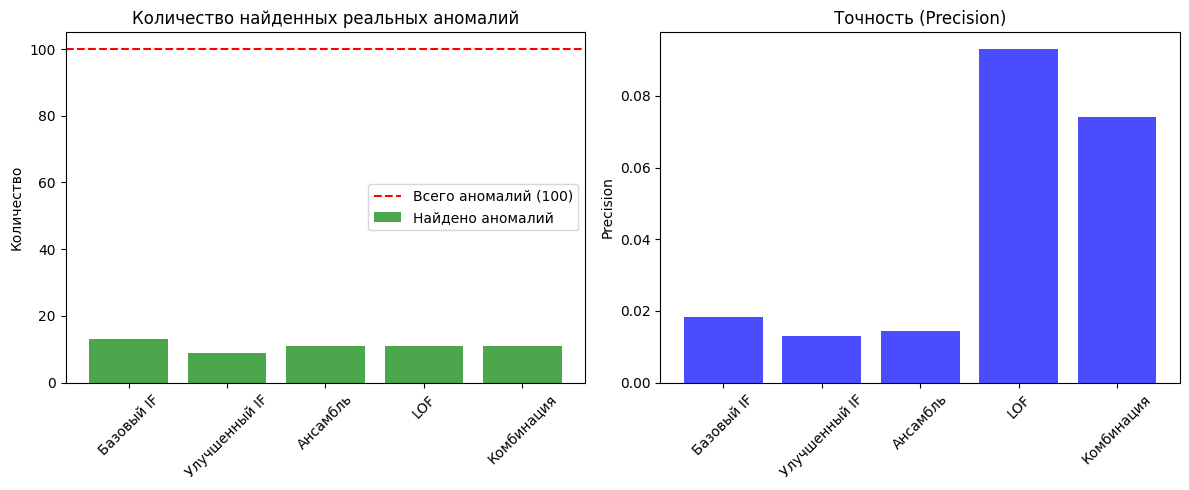

In [12]:
methods_data = [
    ["Базовый IF", 13, 0.0184, 0.13, 0.0322],
    ["Улучшенный IF", 9, 0.0129, 0.09, 0.0225],
    ["Ансамбль", 11, 0.0145, 0.11, 0.0256],
    ["LOF", 11, 0.0931, 0.66, 0.1632],
    ["Комбинация", 11, 0.0740, 0.66, 0.1331]
]

print("\nСравнение методов:")
print("-"*80)
print(f"{'Метод':<20} {'Найдено':<10} {'Precision':<12} {'Recall':<10} {'F1':<10}")
print("-"*80)
for method in methods_data:
    print(f"{method[0]:<20} {method[1]:<10} {method[2]:<12.4f} {method[3]:<10.2f} {method[4]:<10.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

methods_names = [m[0] for m in methods_data]
found_counts = [m[1] for m in methods_data]
false_positives = [695, 690, 747, 107, 107]

axes[0].bar(methods_names, found_counts, color='green', alpha=0.7, label='Найдено аномалий')
axes[0].set_title('Количество найденных реальных аномалий')
axes[0].set_ylabel('Количество')
axes[0].tick_params(axis='x', rotation=45)
axes[0].axhline(y=100, color='red', linestyle='--', label='Всего аномалий (100)')
axes[0].legend()

axes[1].bar(methods_names, [m[2] for m in methods_data], color='blue', alpha=0.7)
axes[1].set_title('Точность (Precision)')
axes[1].set_ylabel('Precision')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Подготовьте выборку: удалите столбцы `['id', 'date', 'price', 'zipcode']`, сформируйте обучающую и тестовую выборки по 10 тысяч домов.

Добавьте в тестовую выборку 10 новых объектов, в каждом из которых испорчен ровно один признак — например, это может быть дом из другого полушария, из далёкого прошлого или будущего, с площадью в целый штат или с таким числом этажей, что самолётам неплохо бы его облетать стороной.

Посмотрим на методы обнаружения аномалий на более простых данных — уж на табличном датасете с 19 признаками всё должно работать как надо!

Скачайте данные о стоимости домов: https://www.kaggle.com/harlfoxem/housesalesprediction/data

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('kc_house_data.csv')

cols_to_drop = ['id', 'date', 'price', 'zipcode']
df_clean = df.drop(columns=cols_to_drop)

np.random.seed(42)
idx = np.random.permutation(len(df_clean))
train_idx = idx[:10000]
test_idx = idx[10000:20000]

X_train_houses = df_clean.iloc[train_idx].copy()
X_test_houses = df_clean.iloc[test_idx].copy()

anomalies_list = []

a1 = X_test_houses.iloc[0].copy()
a1['lat'] = -a1['lat']
a1['long'] = -a1['long'] + 180
anomalies_list.append(a1)

a2 = X_test_houses.iloc[1].copy()
a2['yr_built'] = 1650
anomalies_list.append(a2)

a3 = X_test_houses.iloc[2].copy()
a3['yr_built'] = 2050
anomalies_list.append(a3)

a4 = X_test_houses.iloc[3].copy()
a4['sqft_living'] = 1_000_000
a4['sqft_lot'] = 10_000_000
anomalies_list.append(a4)

a5 = X_test_houses.iloc[4].copy()
a5['floors'] = 150
anomalies_list.append(a5)

a6 = X_test_houses.iloc[5].copy()
a6['sqft_living'] = -500
anomalies_list.append(a6)

a7 = X_test_houses.iloc[6].copy()
a7['bedrooms'] = 0
a7['bathrooms'] = 0
anomalies_list.append(a7)

a8 = X_test_houses.iloc[7].copy()
a8['bedrooms'] = 100
anomalies_list.append(a8)

a9 = X_test_houses.iloc[8].copy()
a9['view'] = 5
a9['condition'] = 1
anomalies_list.append(a9)

a10 = X_test_houses.iloc[9].copy()
a10['waterfront'] = 5
anomalies_list.append(a10)

anomalies_df = pd.DataFrame(anomalies_list)

X_test_augmented = pd.concat([X_test_houses, anomalies_df], ignore_index=True)
y_true_labels = np.array([0] * len(X_test_houses) + [1] * len(anomalies_list))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_houses)
X_test_scaled = scaler.transform(X_test_augmented)

print("ДАННЫЕ ПОДГОТОВЛЕНЫ")
print(f"Обучающая выборка: {X_train_houses.shape}")
print(f"Тестовая выборка: {X_test_augmented.shape}")
print(f"Из них аномалий: {len(anomalies_list)}")
print(f"Признаков: {X_train_houses.shape[1]}")

ДАННЫЕ ПОДГОТОВЛЕНЫ
Обучающая выборка: (10000, 17)
Тестовая выборка: (10010, 17)
Из них аномалий: 10
Признаков: 17


**Задание 9. (2 балла)**

Примените IsolationForest для поиска аномалий в этих данных, запишите их качество (как и раньше, это precision и recall). Проведите исследование:

Нарисуйте распределения всех признаков и обозначьте на этих распределениях объекты, которые признаны аномальными.

  Precision: 0.0030
  Recall: 0.3000
  F1-score: 0.0059

МАТРИЦА ОШИБОК:
              Норма  Аномалия
Норма:         8990     1010
Аномалия:         7        3

Найдено аномалий: 3 из 10
Найденные аномалии:
  - Др. полушарие
  - Гигант
  - Вид/сост
ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ: 


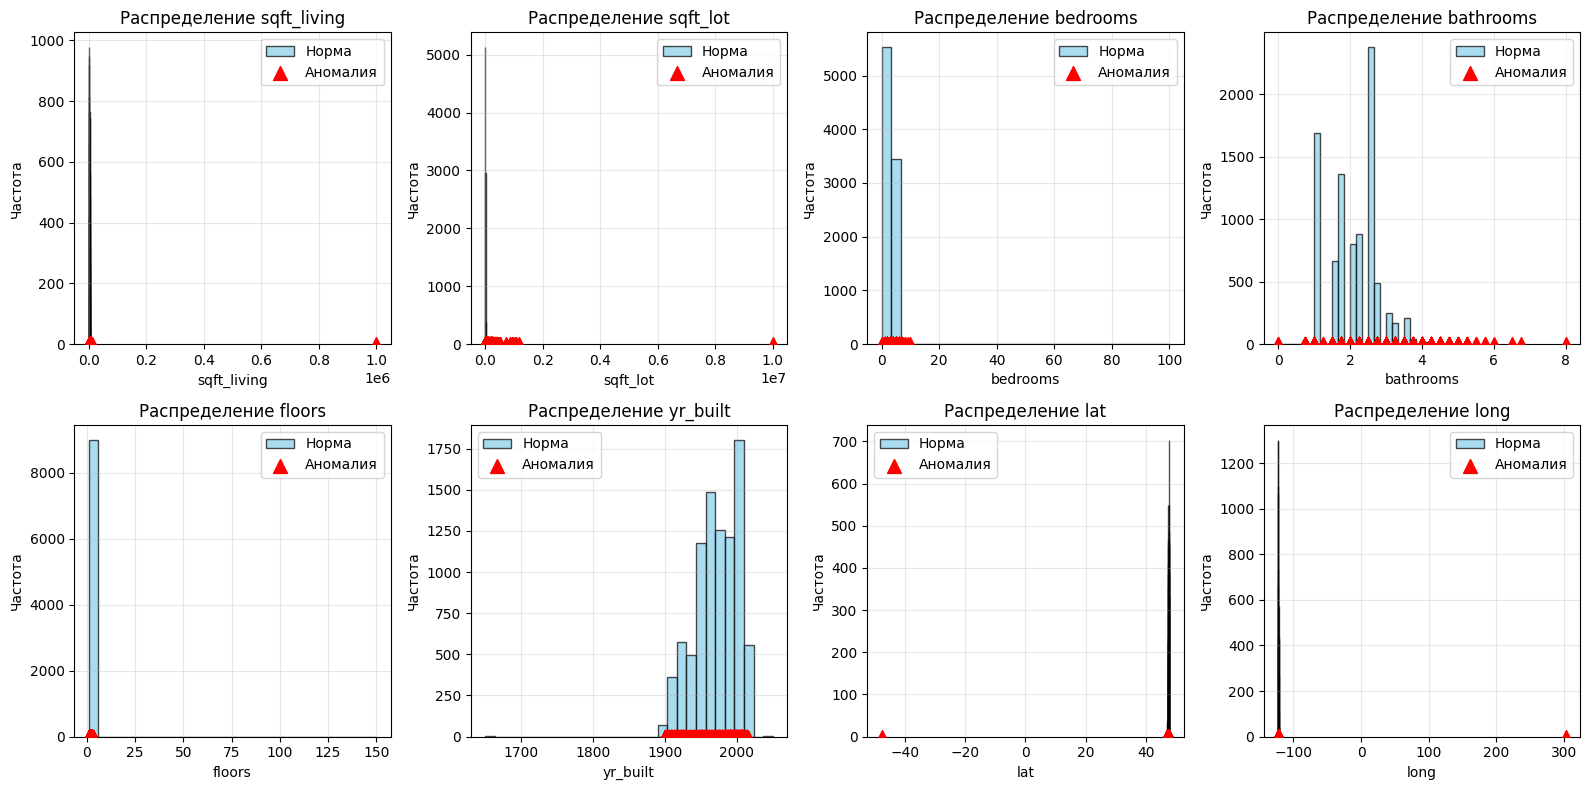

Всего найдено аномалий: 1013

Значения признаков для найденных аномалий:

Объект 3:
  Тип: ЛОЖНАЯ аномалия
  sqft_living: 2990.00
  bedrooms: 3.00
  floors: 2.00
  yr_built: 1951.00
  lat: 47.76
  long: -122.28

Объект 11:
  Тип: ЛОЖНАЯ аномалия
  sqft_living: 4010.00
  bedrooms: 4.00
  floors: 2.00
  yr_built: 1990.00
  lat: 47.54
  long: -122.21

Объект 21:
  Тип: ЛОЖНАЯ аномалия
  sqft_living: 4320.00
  bedrooms: 5.00
  floors: 1.00
  yr_built: 1967.00
  lat: 47.40
  long: -122.06

Объект 23:
  Тип: ЛОЖНАЯ аномалия
  sqft_living: 2350.00
  bedrooms: 5.00
  floors: 2.00
  yr_built: 1924.00
  lat: 47.56
  long: -122.27

Объект 30:
  Тип: ЛОЖНАЯ аномалия
  sqft_living: 2170.00
  bedrooms: 4.00
  floors: 2.00
  yr_built: 1982.00
  lat: 47.62
  long: -122.29


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

iso_forest = IsolationForest(
    contamination=0.1,
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(X_train_scaled)

y_pred = iso_forest.predict(X_test_scaled)
y_pred_binary = np.where(y_pred == -1, 1, 0)

precision = precision_score(y_true_labels, y_pred_binary)
recall = recall_score(y_true_labels, y_pred_binary)
f1 = f1_score(y_true_labels, y_pred_binary)

print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-score: {f1:.4f}")

cm = confusion_matrix(y_true_labels, y_pred_binary)
print(f"\nМАТРИЦА ОШИБОК:")
print(f"              Норма  Аномалия")
print(f"Норма:        {cm[0,0]:5d}    {cm[0,1]:5d}")
print(f"Аномалия:     {cm[1,0]:5d}    {cm[1,1]:5d}")

print(f"\nНайдено аномалий: {cm[1,1]} из {len(anomalies_df)}")
if cm[1,1] > 0:
    anomaly_indices = np.where((y_true_labels == 1) & (y_pred_binary == 1))[0]
    anomaly_types = [
        'Др. полушарие', 'Прошлое', 'Будущее', 'Гигант', 'Небоскреб',
        'Отриц. площадь', '0 спален', '100 спален', 'Вид/сост', 'Waterfront'
    ]
    print("Найденные аномалии:")
    for idx in anomaly_indices:
        anom_idx = idx - len(X_test_houses)
        if 0 <= anom_idx < len(anomaly_types):
            print(f"  - {anomaly_types[anom_idx]}")
print("ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ: ")

plot_df = X_test_augmented.copy()
plot_df['anomaly'] = y_pred_binary

features_to_plot = [
    'sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms',
    'floors', 'yr_built', 'lat', 'long'
]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    ax.hist(
        plot_df[plot_df['anomaly'] == 0][feature],
        bins=30, alpha=0.7, label='Норма', color='skyblue', edgecolor='black'
    )

    anomaly_data = plot_df[plot_df['anomaly'] == 1][feature]
    if len(anomaly_data) > 0:
        ax.scatter(
            anomaly_data,
            [0] * len(anomaly_data),
            color='red', s=100, label='Аномалия', zorder=5, marker='^'
        )

    ax.set_xlabel(feature)
    ax.set_ylabel('Частота')
    ax.set_title(f'Распределение {feature}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

anomaly_indices = np.where(y_pred_binary == 1)[0]
print(f"Всего найдено аномалий: {len(anomaly_indices)}")

if len(anomaly_indices) > 0:
    print("\nЗначения признаков для найденных аномалий:")
    for idx in anomaly_indices[:5]:
        print(f"\nОбъект {idx}:")
        obj = X_test_augmented.iloc[idx]
        is_true = y_true_labels[idx] == 1
        true_label = "ИСТИННАЯ" if is_true else "ЛОЖНАЯ"
        print(f"  Тип: {true_label} аномалия")
        if is_true:
            anom_idx = idx - len(X_test_houses)
            if 0 <= anom_idx < len(anomaly_types):
                print(f"  Вид: {anomaly_types[anom_idx]}")
        for feat in ['sqft_living', 'bedrooms', 'floors', 'yr_built', 'lat', 'long']:
            print(f"  {feat}: {obj[feat]:.2f}")